# TME4 - Problèmes de Bandits

## Lecture des donnés

In [106]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv

def read_data():
    articles = {}
    x = []
    y = []
    with open( "CTR.txt", "rb" ) as csvfile:
        reader = csv.reader(csvfile, delimiter=':')
        for row in reader:
            article_repr = row[1].split(";") # représentation article en 5 dims
            article_click_rate = row[2].split(";") # taux de clicks de 10 annonceurs ( reward )
            x.append(article_repr)
            y.append(article_click_rate)
    return np.array(x, dtype=float),np.array(y, dtype=float)


## Calcule du reward et du regret

In [100]:
def eval(actions, y, methode):
    t = actions.shape[0]
    regret = np.zeros((t))
    reward = np.zeros((t))
    for i in xrange(t):
        reward[i] = y[i][actions[i]]
        regret[i] = y[i].max() - reward[i]
    print methode
    print "Mean reward: ", reward.mean()
    print "Mean regret: ", regret.mean()
    print ""
    return reward, regret

## Baselines
### Stratégie Random
Choisir un annonceur aléatoirement 

In [73]:
def random_strategy(y):
    return np.random.randint(0, y.shape[1], y.shape[0])

### Strategie StaticBest
Choisir l'annonceur avec le meilleur taux de clics cumulés

In [88]:
def staticbest_strategy(y):
    return y.cumsum(axis=0).argmax(axis=1)

### Stratégie Optimale (triche)
A chaque itération, on choisis l'annonceur qui a le meilleur taux de clic à cette itération.

In [74]:
def optimal_strategy(y):
    return y.argmax(axis=1)

# UCB

In [75]:
def UCB(y):
    y_hat = np.zeros( len(y), dtype=int )
    cum   = np.zeros((y.shape[1]))
    count = np.ones((y.shape[1]))
    mu    = np.zeros((y.shape[1]))
    for i in xrange(len(y)):
        pred_index         = ( mu + np.sqrt(2 * np.log(i+1) / count) ).argmax()
        y_hat[i]           = pred_index
        cum[pred_index]   += y[i][pred_index]
        count[pred_index] += 1
        mu[pred_index]     = cum[pred_index] / count[pred_index]
    return y_hat

 # LinUCB
(Slide 39)
Développer l'algo linUCB vue en cours, cet algorithme prend en compte le contexte de la décision qui est très utile pour prévoir la variation des taux obsérvés.


In [76]:
import sys

def LinUCB(x, y, alpha=0.1):
    y_hat = np.zeros(len(x), int)
    
    A = np.identity(x.shape[1]).reshape(1,x.shape[1],x.shape[1]).repeat(y.shape[1],axis=0)
    b = np.zeros((y.shape[1],x.shape[1]))
    
    theta = np.zeros((y.shape[1],x.shape[1]))
    p = np.zeros((y.shape[1]))
    
    for i in xrange(len(x)): # pour chaque annonce
        
        for a in xrange(y.shape[1]): # pourchaque annonceur
            A_inv = np.linalg.inv(A[a])      # ligne 8
            theta[a] = np.dot( A_inv, b[a] ) 
            p[a] = np.dot(theta[a].T, x[i]) + alpha * np.sqrt(  np.dot(x[i], np.dot(A_inv,x[i]) )) #ligne 9
        
        argmaxes = np.where(p == p.max())[0] # ligne 11
        pred = np.random.choice( argmaxes ) 
        y_hat[i] = pred                                                          
        A[pred] += np.dot(x[i], x[i]) # ligne 12
        b[pred] += y[i][pred] * x[i] # ligne 13
    return y_hat


# Test

In [101]:
x,y = read_data()

pred_random = random_strategy(y)
pred_staticbest = staticbest_strategy(y)
pred_optimal = optimal_strategy(y)
pred_ucb = UCB(y)
pred_linucb = LinUCB(x,y)

reward_random, regret_random = eval(pred_random, y, "Random")
reward_staticbest, regret_staticbest = eval(pred_staticbest, y, "Static Best")
reward_optimal, regret_optimal = eval(pred_optimal, y, "Optimal")
reward_ucb, regret_ucb = eval(pred_ucb, y, "UCB")
reward_linucb, regret_linucb = eval(pred_linucb, y, "LinUCB")

Random
Mean reward:  0.0799602184118
Mean regret:  0.226440428735

Static Best
Mean reward:  0.267979672173
Mean regret:  0.0384209749737

Optimal
Mean reward:  0.306400647147
Mean regret:  0.0

UCB
Mean reward:  0.20141435233
Mean regret:  0.104986294817

LinUCB
Mean reward:  0.257079656836
Mean regret:  0.0493209903108



# Comparaison
## Reward

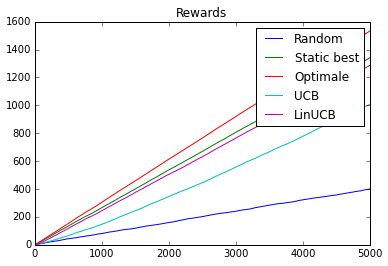

In [104]:
t = range(len(x))

plt.figure()
plt.plot(t, reward_random.cumsum(), label='Random')
plt.plot(t, reward_staticbest.cumsum(), label='Static best')
plt.plot(t, reward_optimal.cumsum(), label='Optimale')
plt.plot(t, reward_ucb.cumsum(), label='UCB')
plt.plot(t, reward_linucb.cumsum(), label='LinUCB')
plt.legend()
plt.title('Rewards')



## Regret

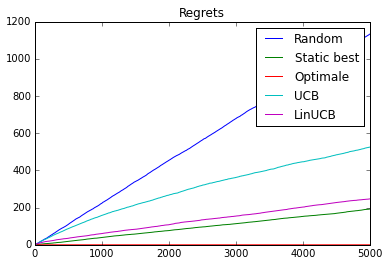

In [105]:
t = range(len(x))

plt.figure()
plt.plot(t, regret_random.cumsum(), label='Random')
plt.plot(t, regret_staticbest.cumsum(), label='Static best')
plt.plot(t, regret_optimal.cumsum(), label='Optimale')
plt.plot(t, regret_ucb.cumsum(), label='UCB')
plt.plot(t, regret_linucb.cumsum(), label='LinUCB')
plt.legend()
plt.title('Regrets')